In [ ]:
from google.colab import drive 
drive.mount('/saurabh' , force_remount = True) 

Mounted at /saurabh


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jan  4 09:40:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **mcfly installation**

In [ ]:
pip install mcfly

# **Import important libraries**

In [ ]:
import os
import statistics
import csv
import itertools
#import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import mcfly

In [ ]:
cd /saurabh/My Drive/Datasets/har/wisdm-dataset/

/saurabh/My Drive/Datasets/har/wisdm-dataset


In [ ]:
ls

activity_key.txt             HARWatchGRU_Optuna.csv
arff_files/                  inception/
arffmagic-master/            inception_phone/
change_raw_act.pl            model1_plot.png
data/                        model_plot2.png
deepconv1/                   model_plot3.png
deepconvlstm/                model_plot4.png
HAR_Simple_Keras.csv         model_plot_cnnlstm.png
HAR_Simple_model_000003.h5   model_plot.png
HAR_Simple_Optuna.csv        multichannel.png
HARTrain1_Keras.csv          phone.df
HARTrain1_model_000013.h5    raw/
HARTrain1_Optuna.csv         README.txt
HARTrain_Keras.csv           resnet/
HARTrain_Optuna.csv          resnetsmarphone/
HARWatchGRU_Keras.csv        watch.df
HARWatchGRU_model_000000.h5  WISDM-dataset-description.pdf


In [ ]:
watch = pd.read_pickle('watch.df')

In [ ]:
watch.shape

(3731135, 9)

## **Mapping the 18 activities into 3 Groups**

In [ ]:
def activity_mapper(activity):
    if(activity in ['A', 'B', 'C', 'D', 'E', 'M']):
        return 0
    elif(activity in ['P', 'O', 'F', 'Q', 'R','G', 'S']):
        return 1
    else:
        return 2
watch['activity'] = watch['activity'].apply(activity_mapper)

In [ ]:
watch.activity.value_counts()

1    1462798
0    1235394
2    1032943
Name: activity, dtype: int64

In [ ]:
activity_map = {
    0: 'Ambulation Oriented',
    1: 'Hand Oriented General',
    2: 'Hand Oriented Eating'
}

In [ ]:
activities = sorted(activity_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

## **Data Transformation using a sliding windows of 10 seconds = 200 (10 * 20) data points and stride of 50**

In [ ]:
window_size = 200
stride = 50
frames = []
for i in tqdm(range(0, len(watch)-window_size, stride)):
    window = watch.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
      frames.append(window)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
#activities = sorted(act_map.keys())
#activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

#for each frame replace label with activity
for frame in tqdm(frames):
    X_list.append(frame[['watch_accel_x', 'watch_accel_y', 'watch_accel_z', 'watch_gyro_x', 'watch_gyro_y', 'watch_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])
    #y_list.append(frame.iloc[0][['activity']].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [ ]:
print(X.shape)
print(y.shape)

(73101, 200, 6)
(73101, 3)


In [ ]:
print(X.shape[1:])

(200, 6)


# **Train , Validation , Test Split**

In [ ]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

#train
print("X_train: ",X_train.shape)

#dev
print("X_val: ",X_val.shape)

#test
print("X_test: ",X_test.shape)

print("Y_train: ",y_train.shape)
print("Y_val: ",y_val.shape)
print("Y_test: ",y_test.shape)

X_train:  (43860, 200, 6)
X_val:  (14620, 200, 6)
X_test:  (14621, 200, 6)
Y_train:  (43860, 3)
Y_val:  (14620, 3)
Y_test:  (14621, 3)


In [ ]:
num_classes = y_train.shape[1]
metric = 'accuracy'

In [ ]:
print(num_classes)

3


## **DeepConvLSTM implemmentation using McFLY**

In [ ]:
models = mcfly.modelgen.generate_models(X_train.shape,
                                        number_of_classes=num_classes,
                                        number_of_models = 4,
                                        model_types = ['DeepConvLSTM'],
                                        metrics=[metric])

In [ ]:
models_to_print = range(len(models))
for i, item in enumerate(models):
    if i in models_to_print:
        model, params, model_types = item
        print("-------------------------------------------------------------------------------------------------------")
        print("Model " + str(i))
        print(" ")
        print("Hyperparameters:")
        print(params)
        print(" ")
        print("Model description:")
        model.summary()
        print(" ")
        print("Model type:")
        print(model_types)
        print(" ")

-------------------------------------------------------------------------------------------------------
Model 0
 
Hyperparameters:
{'learning_rate': 0.008257296528061436, 'regularization_rate': 0.00012098664501816279, 'filters': [79, 32, 94, 66, 25, 56, 78, 34, 71, 58], 'lstm_dims': [41]}
 
Model description:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 200, 6)            24        
_________________________________________________________________
reshape (Reshape)            (None, 200, 6, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 6, 79)        316       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 6, 79)        316       
_________________________________________________________________
activatio

In [ ]:
pwd

'/saurabh/My Drive/Datasets/har/wisdm-dataset'

In [ ]:
directory_to_extract_to = os.path.join('.', 'deepconvsmartfin')

In [ ]:
# Define directory where the results, e.g. json file, will be stored
resultpath = os.path.join(directory_to_extract_to, 'models')
if not os.path.exists(resultpath):
    os.makedirs(resultpath)

In [ ]:
print('X shape:', X_train.shape)
print('y shape:', y_train.shape)

X shape: (43860, 200, 6)
y shape: (43860, 3)


In [ ]:
from mcfly.find_architecture import train_models_on_samples

outputfile = os.path.join(resultpath, 'modelcomparison.json')
histories, val_accuracies, val_losses = train_models_on_samples(X_train, y_train,
                                                                X_val, y_val,
                                                                models, nr_epochs=10,
                                                                subset_size= None,
                                                                early_stopping_patience = 3,
                                                                verbose=True,
                                                                outputfile=outputfile,
                                                                metric=metric,batch_size = 64)

/usr/local/lib/python3.6/dist-packages/mcfly/find_architecture.py:134: UserWarning: Argument 'metric' is deprecated and will be ignored.
  warnings.warn("Argument 'metric' is deprecated and will be ignored.")


Training model 0 DeepConvLSTM
Epoch 1/10
686/686 [==============================] - 48s 53ms/step - loss: 0.9071 - accuracy: 0.6062 - val_loss: 0.7078 - val_accuracy: 0.7079
Epoch 2/10
686/686 [==============================] - 34s 50ms/step - loss: 0.6482 - accuracy: 0.7521 - val_loss: 1.6561 - val_accuracy: 0.4172
Epoch 3/10
686/686 [==============================] - 34s 50ms/step - loss: 0.6113 - accuracy: 0.7835 - val_loss: 2.4359 - val_accuracy: 0.5287
Epoch 4/10
686/686 [==============================] - 34s 50ms/step - loss: 0.4813 - accuracy: 0.8277 - val_loss: 1.1564 - val_accuracy: 0.4568
Epoch 00004: early stopping
Training model 1 DeepConvLSTM
Epoch 1/10
686/686 [==============================] - 42s 54ms/step - loss: 2.0298 - accuracy: 0.7205 - val_loss: 1.4603 - val_accuracy: 0.6278
Epoch 2/10
686/686 [==============================] - 35s 51ms/step - loss: 0.9931 - accuracy: 0.7913 - val_loss: 0.7249 - val_accuracy: 0.8263
Epoch 3/10
686/686 [============================

In [ ]:
best_model_index = 1

In [ ]:
best_model_index

1

In [ ]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 DeepConvLSTM {'learning_rate': 0.0008332444799617763, 'regularization_rate': 0.006097885018795986, 'filters': [96, 44, 43, 52, 79, 14, 18], 'lstm_dims': [79, 57, 47]}


In [ ]:
best_params

{'filters': [96, 44, 43, 52, 79, 14, 18],
 'learning_rate': 0.0008332444799617763,
 'lstm_dims': [79, 57, 47],
 'regularization_rate': 0.006097885018795986}

In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_11 (Batc (None, 200, 6)            24        
_________________________________________________________________
reshape_2 (Reshape)          (None, 200, 6, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 200, 6, 96)        384       
_________________________________________________________________
batch_normalization_12 (Batc (None, 200, 6, 96)        384       
_________________________________________________________________
activation_11 (Activation)   (None, 200, 6, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 200, 6, 44)        12716     
_________________________________________________________________
batch_normalization_13 (Batc (None, 200, 6, 44)       

In [ ]:
from keras.utils.vis_utils import plot_model

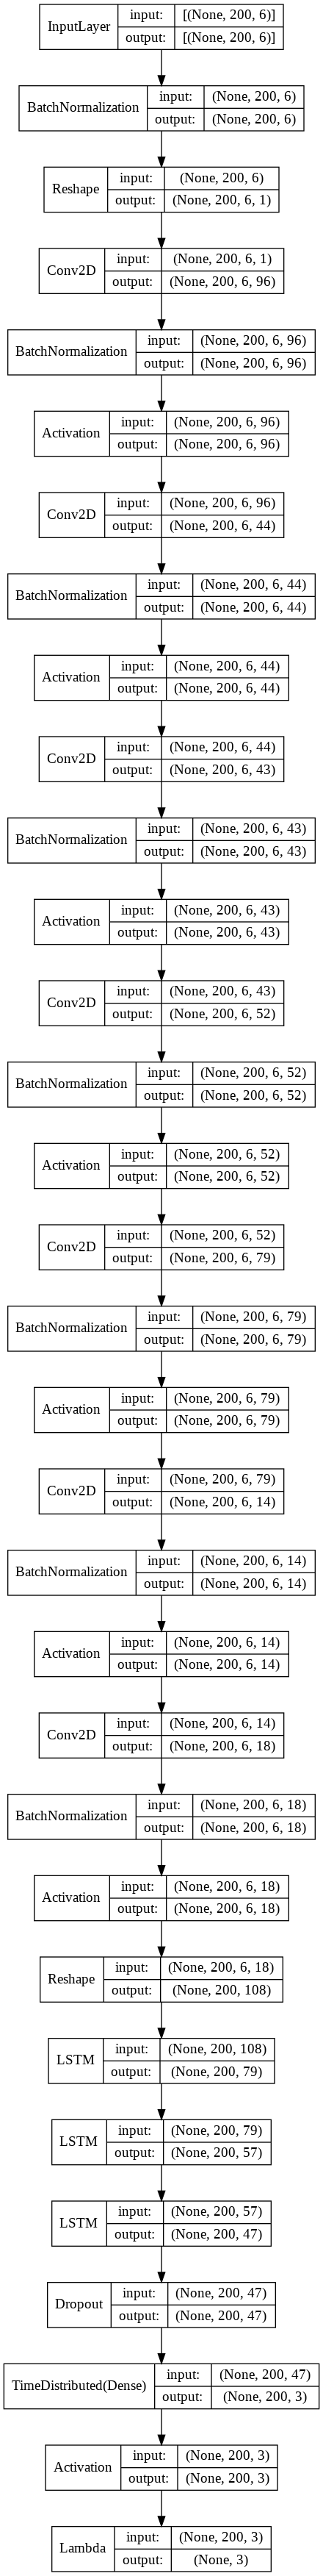

In [ ]:
plot_model(best_model, to_file='model_plot4.png', show_shapes=True,rankdir = 'TB',expand_nested = False,  show_layer_names=False, show_dtype =False)

In [ ]:
# Reverse activity encoding encodes index like 3 -> eating sandwich
reverse_activity_encoding = {v: activity_map[k] for k, v in activity_encoding.items()}
lstm_y_val_pred = best_model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = lstm_y_val_pred.argmax(axis=1)

lstm_actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
lstm_predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

##### Below is Final Test Set results ######
lstm_y_test_pred = best_model.predict(X_test)
lstm_y_test_argmax = y_test.argmax(axis=1)

lstm_y_test_pred_argmax = lstm_y_test_pred.argmax(axis=1)

lstm_actual_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_argmax]
lstm_predicted_test_activities = [reverse_activity_encoding[i] for i in lstm_y_test_pred_argmax]

In [ ]:
from sklearn.metrics import classification_report 
print("             Smartwatch Results with DeepConvLSTM for Validation Set\n\n" + classification_report(lstm_predicted_val_activities,lstm_actual_val_activities , digits = 4))
print("             Smartwatch Results with DeepConvLSTM for Test Set\n\n" + classification_report(lstm_predicted_test_activities,lstm_actual_test_activities, digits = 4))

             Smartwatch Results with DeepConvLSTM for Validation Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.8083    0.9490    0.8730      3998
 Hand Oriented Eating     0.8651    0.9017    0.8830      3926
Hand Oriented General     0.9515    0.8290    0.8860      6696

             accuracy                         0.8813     14620
            macro avg     0.8750    0.8932    0.8807     14620
         weighted avg     0.8891    0.8813    0.8817     14620

             Smartwatch Results with DeepConvLSTM for Test Set

                       precision    recall  f1-score   support

  Ambulation Oriented     0.7988    0.9460    0.8662      4093
 Hand Oriented Eating     0.8588    0.9066    0.8820      3823
Hand Oriented General     0.9545    0.8169    0.8803      6705

             accuracy                         0.8765     14621
            macro avg     0.8707    0.8898    0.8762     14621
         weighted avg     0.8859    0.8765

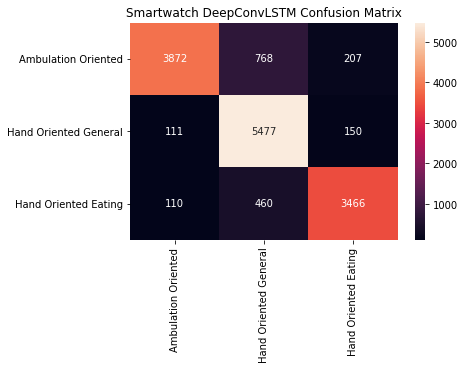

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
lstm_cm = confusion_matrix(lstm_y_test_argmax, lstm_y_test_pred_argmax)
df_cm = pd.DataFrame(lstm_cm, index = [reverse_activity_encoding[i] for i in range(3)], columns = [reverse_activity_encoding[i] for i in range(3)])
#plt.figure(figsize = (12,12))
plt.title('Smartwatch DeepConvLSTM Confusion Matrix')
sns.heatmap(df_cm, annot=True, fmt='g')